## Reading IMDB and Rotten Tomatoes data in

We download a csv file from [here](https://www.aggdata.com/awards/oscar) which contains all the nominated movies from the 1st(1927) to the 83rd(2010) Oscar Award and we manually updated the file so that it's updated to 2014.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import requests
import json
import bs4
from bs4 import BeautifulSoup
from tqdm import tqdm
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
academy = pd.read_csv("academy_awards.csv")
academy = academy[['Year', 'Category', 'Nominee', 'Additional Info', 'Won?']]
academy.head()

,Year,Category,Nominee,Additional Info,Won?
0,2014 (87th),Actor -- Leading Role,Steve Carell,"Foxcatcher {""John du Pont""}",NO
1,2014 (87th),Actor -- Leading Role,Bradley Cooper,"American Sniper {""Chris Kyle""}",NO
2,2014 (87th),Actor -- Leading Role,Benedict Cumberbatch,"The Imitation Game {""Alan Turing""}",NO
3,2014 (87th),Actor -- Leading Role,Michael Keaton,Birdman or (The Unexpected Virtue of Ignorance...,NO
4,2014 (87th),Actor -- Leading Role,Eddie Redmayne,"The Theory of Everything {""Stephen Hawking""}",YES


Number of nominated instances (can have repeated movies): 10271


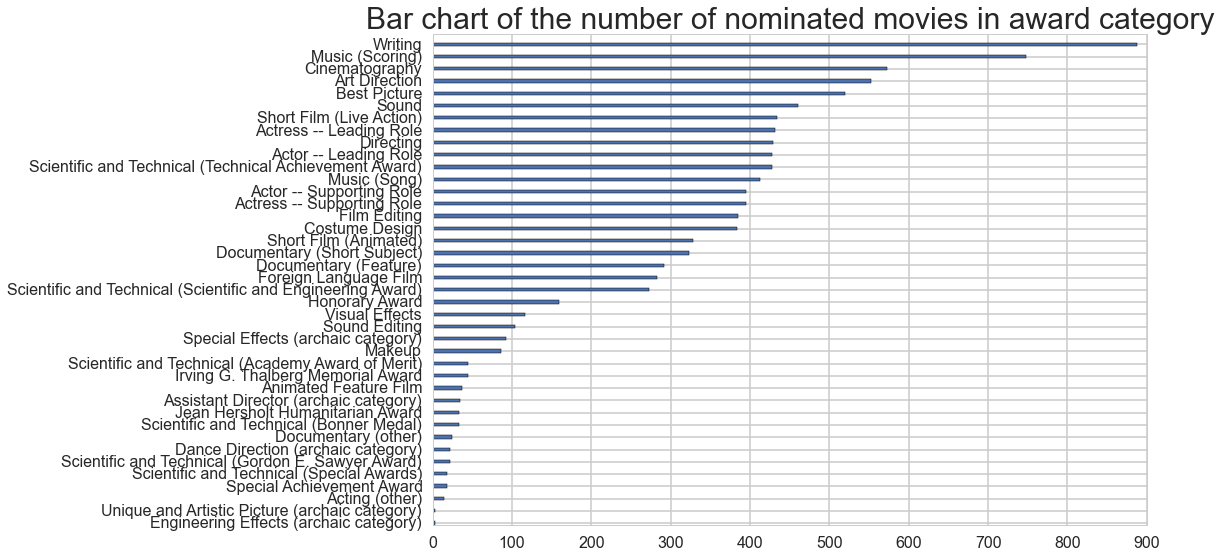

In [3]:
print "Number of nominated instances (can have repeated movies):", academy.shape[0]

cnts = academy.groupby('Category').Year.count()
test = dict(zip(cnts.index, cnts.values))
#test  = sorted(test.items(), key=lambda x: x[1])
test = pd.DataFrame.from_dict(test.items())
test.columns = ['category', 'cnt']
test.sort(columns='cnt', inplace=True)
#print test.category
ind = np.arange(len(test.cnt)*3, step=3);
plt.barh(ind, test.cnt);
plt.yticks(ind + 0.35, list(test.category));
plt.title('Bar chart of the number of nominated movies in award category', size=30);
plt.figure(figsize=(40,50));

For the purpose of predicting awards for the best movies, we are going to only keep the movies that have been nominated or won **'Actor -- Leading Role', 'Actor -- Supporting Role', 'Actress -- Leading Role', 'Actress -- Supporting Role', 'Best Picture' and 'Directing'**. The other award categories are somewhat less relevant.

In [4]:
academy = academy.loc[academy.Category.isin(['Actor -- Leading Role',
                                       'Actor -- Supporting Role',
                                       'Actress -- Leading Role',
                                      'Actress -- Supporting Role',
                                      'Best Picture',
                                      'Directing'])]

Number of nominated movies in selected award category: 2598


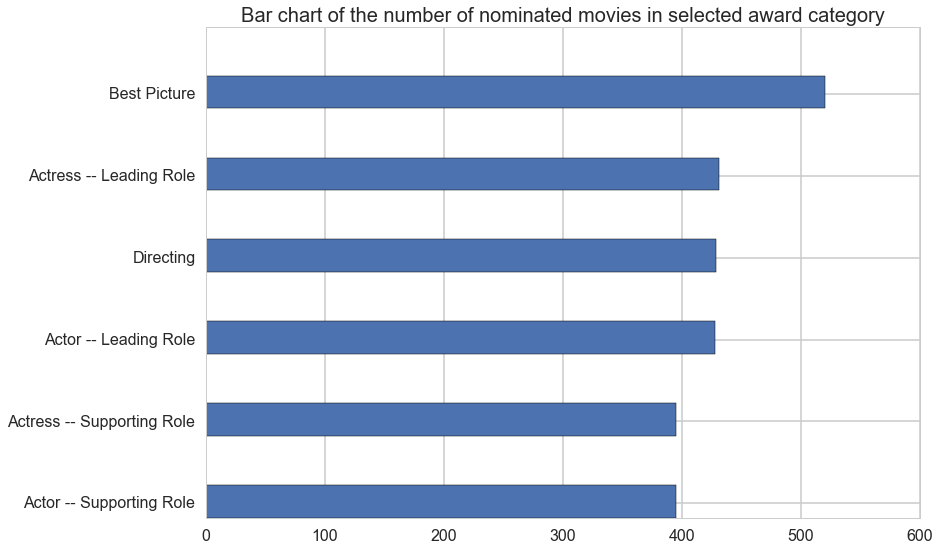

In [5]:
print "Number of nominated movies in selected award category:", academy.shape[0]
cnts = academy.groupby('Category').Nominee.count()
#print cnts
test = dict(zip(cnts.index, cnts.values))
test = pd.DataFrame.from_dict(test.items())
test.columns = ['category', 'cnt']
test.sort(columns='cnt', inplace=True)
#print test
ind = np.arange(len(test.cnt)*2, step=2);
plt.barh(ind, test.cnt);
plt.yticks(ind + 0.35, list(test.category));
plt.title('Bar chart of the number of nominated movies in selected award category', size=20);
plt.figure(figsize=(40,50));

### Extract the movie titles and put them into a list

When the Category is **Best Picture** or **Directing**, the movie title is in the **Nominee** field, when a movie belongs to other categories, the movie title is in the **additional info** field, which we will need to use regular expression to parse the title. In the end, we found that there are 1251 unique movie titles.


In [6]:
import re
result = []
for ind, row in academy.iterrows():
    if row['Category'] == 'Best Picture':
        result.append(row['Nominee'])
    if row['Category'] == 'Directing':
        result.append(row['Nominee'])
    if row['Category'] != 'Best Picture' and row['Category'] != 'Directing':
        s = str(row['Additional Info'])
        if len(s)!= 0:
            temp = re.split("\\{([^}]*.?)\\}", s)
            result.append(temp[0])

In [7]:
## format the title to put into json queries
titlelist = []
#i = 0 
for t in result:
    #i = i+1
    t = t.strip()
    #s = t.split(" ")
    #ss = '+'.join(s)
    titlelist.append(t)
titlelist = list(set(titlelist)) 
print "Unique movie titles:", len(titlelist)

Unique movie titles: 1251


In [8]:
titlelist[1:10]

['Separate Tables',
 'Naughty Marietta',
 'Disraeli',
 'Breaking Away',
 'For Whom the Bell Tolls',
 'Life of Pi',
 'Damage',
 'The Smiling Lieutenant',
 'The Yearling']

### Read Data from IMDB and Rotten Tomatoes API

In [10]:
import requests
import json

movieslist = []
movienotfound = []
i = 0
for t in tqdm(titlelist, leave=True):
    try:
        time.sleep(0.5)
        #url = "http://www.omdbapi.com/?t={}&y=&plot=full&r=json".format(t)
        #temp = json.loads(requests.get(url).text)
        req = omdb.request(t=t, type='movie', tomatoes=True)
        temp = json.loads(req.text)
        if str(temp['Response'])== 'False':
            movienotfound.append(t)
        if str(temp['Response'])== 'True':
            movieslist.append(temp)
    except: 
        movienotfound.append(t)      

        pass

100%|██████████| 1251/1251 [10:57<00:00,  1.89it/s]


In [11]:
print movienotfound
print
print "Number of movies not found:", len(movienotfound)

["Jacqueline Susann's Once Is Not Enough", 'Good Fellas', 'Les Mis  erables', 'Cries and Whispers', "Federico Fellini's 8-1/2", 'G. I. Joe', 'Drag; and Weary River', 'Clarence Brown', 'All That Money Can Buy', 'The Postman (Il Postino)', "Precious: Based on the Novel 'Push' by Sapphire", '12 Monkeys', 'Z']

Number of movies not found: 13


Some of the movies cannot be found, since there are only a few, we can manually fix them by looking them up in IMDb and find their IMDb ids. 

In [12]:
movietryagain = ['tt0073190', 'tt0099685','tt1707386', 'tt0069467', 'tt0056801',
                 'tt0038120', 'tt0019557', 'tt0020641', 'tt0021310', 'tt0033532', 'tt0119925',
                 'tt0929632', 'tt0114746', 'tt0065234']
movienotfound = []
for t in tqdm(movietryagain, leave=True):
    try:
        #url = "http://www.omdbapi.com/?t={}&y=&plot=full&r=json".format(t)
        #temp = json.loads(requests.get(url).text)
        req = omdb.request(i=t, type='movie', tomatoes=True)
        temp = json.loads(req.text)
    
        if str(temp['Response'])== 'False':
            movienotfound.append(t)
        if str(temp['Response'])== 'True':
            movieslist.append(temp)
    except: 
        print t
        
        pass

100%|██████████| 14/14 [00:00<00:00, 61.73it/s]


In [13]:
print len(movienotfound)
print len(movieslist)

0
1252


## Data Cleaning

In [34]:
movies = pd.DataFrame(movieslist)
print movies.Awards[1]
print "Make sure all the movie type is 'movie':", movies[movies.Type!='movie'].shape[0]
print "Make sure all the movie is found in the api portal:", movies[movies.Response=='False'].shape[0]

def runtime(s):
    ss = s.split()
    if len(ss) > 1 and int(ss[0]) > 60:
        return int(ss[0])
    else:
        return None
    
movies['Runtime'] = movies.apply(lambda r: runtime(r.Runtime), axis=1)
movies[movies.Runtime.isnull()]

Won 2 Oscars. Another 5 wins & 15 nominations.
Make sure all the movie type is 'movie': 0
Make sure all the movie is found in the api portal: 0


,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,Poster,Production,Rated,Released,Response,Runtime,Title,Type,Website,Writer,Year,imdbID,imdbRating,imdbVotes,tomatoConsensus,tomatoFresh,tomatoImage,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoUserMeter,tomatoUserRating,tomatoUserReviews
24,"Craig Sheffer, Eric Roberts, Gary Daniels, Ivá...",N/A,N/A,USA,N/A,James Chankin,"Action, Fantasy, Sci-Fi",English,N/A,Chad Turner (Craig Sheffer) has been implanted...,http://ia.media-imdb.com/images/M/MV5BMjM2OTYw...,N/A,N/A,16 Oct 2012,True,NaN,The Mark,movie,N/A,"Paul Duran, Leland Jourdan, John Patus",2012,tt2058710,3.8,709,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
172,"Alexander Ferrer, Fanny Lyckman",N/A,N/A,Sweden,N/A,Tobias Hansson,Reality-TV,Swedish,N/A,N/A,N/A,N/A,N/A,20 Dec 2012,True,NaN,Fanny & Alexander,movie,N/A,Anders Häger Jönson,2012,tt2659456,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
322,"Shirley Jones, Onna White, Susan Luckey, Buddy...",N/A,N/A,USA,N/A,Scott Benson,"Documentary, Short, Family",English,N/A,Documentary about the making of the 1962 film ...,http://ia.media-imdb.com/images/M/MV5BMTA0OTQz...,N/A,N/A,N/A,True,NaN,Right Here in River City: The Making of Meredi...,movie,N/A,Tom Edwards,1998,tt0258928,7.9,25,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
371,N/A,N/A,N/A,"Portugal, France",N/A,Marta Alvim,Biography,English,N/A,A masseuse is hired to massage all the guests ...,N/A,N/A,N/A,N/A,True,NaN,I'm Not There,movie,N/A,N/A,2009,tt1855567,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
578,"Oldrich Kaiser, Jirí Lábus, Michal Pavlícek, V...",1 win & 2 nominations.,N/A,"Czechoslovakia, West Germany",N/A,Jirí Barta,"Animation, Fantasy, Horror",Czech,N/A,The story of the Pied Piper of Hamelin with a ...,http://ia.media-imdb.com/images/M/MV5BODk1NjE2...,N/A,N/A,01 Sep 1986,True,NaN,The Pied Piper,movie,N/A,"Kamil Pixa (screenplay), Viktor Dyk (novel)",1986,tt0174834,7.9,611,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
933,"Alan Alda, Gary Burghoff, William Christopher,...",N/A,N/A,USA,N/A,N/A,Documentary,English,N/A,N/A,N/A,N/A,N/A,25 Nov 1991,True,NaN,Memories of M*A*S*H,movie,N/A,N/A,1991,tt0188892,8.7,83,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1111,"Will Ferrell, Adam McKay, Pearl McKay",N/A,N/A,USA,N/A,"Drew Antzis, Adam McKay","Short, Comedy",English,N/A,An angry landlord hassles her behind-in-rent t...,N/A,N/A,N/A,01 Apr 2007,True,NaN,The Landlord,movie,N/A,"Will Ferrell, Adam McKay",2007,tt1160329,8.1,"3,803",N/A,N/A,N/A,N/A,N/A,N/A,N/A,86,4.3,359
1164,Lola Petitbon,N/A,N/A,USA,N/A,Satoshi Takamura,"Short, Thriller",English,N/A,N/A,N/A,N/A,N/A,N/A,True,NaN,Adaptation,movie,N/A,N/A,2015,tt4939272,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


When the movie runtime is **NaN**, usually most of the features are missing, so we are going to remove these rows.

In [35]:
## remove games, series and NA types.
movies = movies[movies.Type=='movie']
movies = movies[movies.Response=='True']

## Remove those rows with NaN runtime.
print "Number of rows removed:", movies[movies.Runtime.isnull()].shape[0]
movies = movies[movies.Runtime > 0]

Number of rows removed: 8


We need to extract the correspondeing information from **award** and put them into individual columns.

In [36]:
def numNomiOscar(s):
    re1='(Nominated)'
    re2='.*?'
    re3='(\\d+)'
    re4='.*?'
    re5='(Oscar)'
    re6='.*?'

    rg = re.compile(re1+re2+re3+re4+re5+re6,re.IGNORECASE|re.DOTALL)
    
    m = rg.search(s)
    if m:
        return int(m.group(2))
    else:
        return 0

def numWonOscar(s):
    re1='(Won)'
    re2='.*?'
    re3='(\\d+)'
    re4='.*?'
    re5='(Oscar)'
    re6='.*?'
    
    rg = re.compile(re1+re2+re3+re4+re5+re6,re.IGNORECASE|re.DOTALL)
    m = rg.search(s)
    if m:
        return int(m.group(2))
    else:
        return 0
    
def anotherWins(s):
    re1='(Another)'
    re2='.*?'
    re3='(\\d+)'
    re4='.*?'
    re5='(win)'
    re6='.*?'
    
    rg = re.compile(re1+re2+re3+re4+re5+re6,re.IGNORECASE|re.DOTALL)
    m = rg.search(s)
    if m:
        return int(m.group(2))
    else:
        return 0

def anotherNoms(s):
    re1='.*?'	# Non-greedy match on filler
    re2='\\d+'	# Uninteresting: int
    re3='.*?'	# Non-greedy match on filler
    re4='\\d+'	# Uninteresting: int
    re5='.*?'	# Non-greedy match on filler
    re6='(\\d+)'	# Integer Number 1
    re7='.*?'	# Non-greedy match on filler
    re8='(nomination)'	# Word 1

    rg = re.compile(re1+re2+re3+re4+re5+re6+re7+re8,re.IGNORECASE|re.DOTALL)
    m = rg.search(s)
    if m:
        return int(m.group(1))
    else:
        return 0


In [37]:
movies['Nominated Oscars'] = movies.apply(lambda r: numNomiOscar(r.Awards), axis=1)
movies['Won Oscars'] = movies.apply(lambda r: numWonOscar(r.Awards), axis=1)
movies['Othter wins'] = movies.apply(lambda r: anotherWins(r.Awards), axis=1)
movies['Othter nominations'] = movies.apply(lambda r: anotherNoms(r.Awards), axis=1)
import datetime
from dateutil import parser
movies['Released'] = movies.apply(lambda r: parser.parse(r.Released) if r.Released != 'N/A' else False, axis=1)
movies = movies.drop(['Plot', 'Poster', 'Writer', 'Type', 'Response'], axis=1)
movies = movies
#cols = list(movies.columns.values)
#print cols
movies = movies[[u'imdbID', u'Title', u'Released', u'Awards', u'Director', u'Actors', u'Country', u'Genre', u'Language',
                 u'Rated', u'Runtime', u'Year', u'Metascore', u'imdbRating', u'imdbVotes', u'tomatoConsensus', u'tomatoFresh',
                 u'tomatoMeter', u'tomatoRating', u'tomatoReviews', u'tomatoRotten', u'tomatoUserMeter',
                 u'tomatoUserRating', u'tomatoUserReviews', 'Nominated Oscars', 'Won Oscars', 'Othter wins', 'Othter nominations']]  

Note that the **Actors** and **Director** field may contain more than one person, and soon we would like to incorprate information of actors and directors to build new quantitative feature to measure the qualaity of a movie, so it will be more handy if we could explode the actor list and director list so that we would have multiple rows of under the same movie title but the actor and director field is different.

In [38]:
rows = []
_ = movies.apply(lambda row: [rows.append([row['imdbID'], row['Title'], row['Released'], row['Awards'], row['Director'],
                                           nn.strip(), row['Country'], row['Language'], row[u'Genre'],row['Rated'],
                                           row['Runtime'], row['Year'], row['Metascore'], row['imdbRating'],
                                           row['imdbVotes'], row['tomatoConsensus'], row['tomatoFresh'], row['tomatoMeter'],
                                           row['tomatoRating'], row['tomatoReviews'], row['tomatoRotten'], row['tomatoUserMeter'],
                                           row['tomatoUserRating'], row['tomatoUserReviews'], row['Nominated Oscars'],
                                           row['Won Oscars'], row['Othter wins'], row['Othter nominations']]) 
                         for nn in row.Actors.strip().split(',')], axis=1)
#rows
movies = pd.DataFrame(rows, columns=movies.columns)
movies.head()

,imdbID,Title,Released,Awards,Director,Actors,Country,Genre,Language,Rated,Runtime,Year,Metascore,imdbRating,imdbVotes,tomatoConsensus,tomatoFresh,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Nominated Oscars,Won Oscars,Othter wins,Othter nominations
0,tt0114279,Richard III,1995-12-29 00:00:00,Nominated for 2 Oscars. Another 6 wins & 10 no...,Richard Loncraine,Ian McKellen,"UK, USA",English,"Drama, War",R,104,1995,N/A,7.5,"11,214",This re-imagining of Shakespeare's Crookback K...,43,96,8.1,45,2,85,3.8,6821,2,0,6,10
1,tt0114279,Richard III,1995-12-29 00:00:00,Nominated for 2 Oscars. Another 6 wins & 10 no...,Richard Loncraine,Annette Bening,"UK, USA",English,"Drama, War",R,104,1995,N/A,7.5,"11,214",This re-imagining of Shakespeare's Crookback K...,43,96,8.1,45,2,85,3.8,6821,2,0,6,10
2,tt0114279,Richard III,1995-12-29 00:00:00,Nominated for 2 Oscars. Another 6 wins & 10 no...,Richard Loncraine,Jim Broadbent,"UK, USA",English,"Drama, War",R,104,1995,N/A,7.5,"11,214",This re-imagining of Shakespeare's Crookback K...,43,96,8.1,45,2,85,3.8,6821,2,0,6,10
3,tt0114279,Richard III,1995-12-29 00:00:00,Nominated for 2 Oscars. Another 6 wins & 10 no...,Richard Loncraine,Robert Downey Jr.,"UK, USA",English,"Drama, War",R,104,1995,N/A,7.5,"11,214",This re-imagining of Shakespeare's Crookback K...,43,96,8.1,45,2,85,3.8,6821,2,0,6,10
4,tt0052182,Separate Tables,1959-02-11 00:00:00,Won 2 Oscars. Another 5 wins & 15 nominations.,Delbert Mann,Deborah Kerr,USA,English,"Drama, Romance",UNRATED,100,1958,N/A,7.6,"4,645",N/A,10,77,7.7,13,3,77,3.6,1301,0,2,5,15


In [39]:
rows = []
_ = movies.apply(lambda row: [rows.append([row['imdbID'], row['Title'], row['Released'], row['Awards'], nn.strip(),
                                           row['Actors'], row['Country'], row['Language'], row[u'Genre'],row['Rated'],
                                           row['Runtime'], row['Year'], row['Metascore'], row['imdbRating'],
                                           row['imdbVotes'], row['tomatoConsensus'], row['tomatoFresh'], row['tomatoMeter'],
                                           row['tomatoRating'], row['tomatoReviews'], row['tomatoRotten'], row['tomatoUserMeter'],
                                           row['tomatoUserRating'], row['tomatoUserReviews'], row['Nominated Oscars'],row['Won Oscars'],
                                           row['Othter wins'], row['Othter nominations']]) 
                         for nn in row.Director.strip().split(',')], axis=1)
#rows
movies = pd.DataFrame(rows, columns=movies.columns).set_index('imdbID')
movies.head()

,Title,Released,Awards,Director,Actors,Country,Genre,Language,Rated,Runtime,Year,Metascore,imdbRating,imdbVotes,tomatoConsensus,tomatoFresh,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Nominated Oscars,Won Oscars,Othter wins,Othter nominations
imdbID,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0114279,Richard III,1995-12-29 00:00:00,Nominated for 2 Oscars. Another 6 wins & 10 no...,Richard Loncraine,Ian McKellen,"UK, USA","Drama, War",English,R,104,1995,N/A,7.5,"11,214",This re-imagining of Shakespeare's Crookback K...,43,96,8.1,45,2,85,3.8,6821,2,0,6,10
tt0114279,Richard III,1995-12-29 00:00:00,Nominated for 2 Oscars. Another 6 wins & 10 no...,Richard Loncraine,Annette Bening,"UK, USA","Drama, War",English,R,104,1995,N/A,7.5,"11,214",This re-imagining of Shakespeare's Crookback K...,43,96,8.1,45,2,85,3.8,6821,2,0,6,10
tt0114279,Richard III,1995-12-29 00:00:00,Nominated for 2 Oscars. Another 6 wins & 10 no...,Richard Loncraine,Jim Broadbent,"UK, USA","Drama, War",English,R,104,1995,N/A,7.5,"11,214",This re-imagining of Shakespeare's Crookback K...,43,96,8.1,45,2,85,3.8,6821,2,0,6,10
tt0114279,Richard III,1995-12-29 00:00:00,Nominated for 2 Oscars. Another 6 wins & 10 no...,Richard Loncraine,Robert Downey Jr.,"UK, USA","Drama, War",English,R,104,1995,N/A,7.5,"11,214",This re-imagining of Shakespeare's Crookback K...,43,96,8.1,45,2,85,3.8,6821,2,0,6,10
tt0052182,Separate Tables,1959-02-11 00:00:00,Won 2 Oscars. Another 5 wins & 15 nominations.,Delbert Mann,Deborah Kerr,USA,"Drama, Romance",English,UNRATED,100,1958,N/A,7.6,"4,645",N/A,10,77,7.7,13,3,77,3.6,1301,0,2,5,15


We then explode the **Genre** list as we did for homework 1, and create an indicator variable for each genre.

In [40]:
Genre = set()
for m in movies.Genre:
    Genre.update(g.strip() for g in str(m).split(',') if g != '')
Genre = sorted(Genre)
#make a column for each genre
for genre in Genre:
    movies[genre] = [genre.strip() in str(m).split(', ') for m in movies.Genre]
movies = movies.drop('Genre', axis=1)
movies = movies.sort_index(axis=0)

movies = movies.reset_index()
movies.head(5)


,imdbID,Title,Released,Awards,Director,Actors,Country,Language,Rated,Runtime,Year,Metascore,imdbRating,imdbVotes,tomatoConsensus,tomatoFresh,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Nominated Oscars,Won Oscars,Othter wins,Othter nominations,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0018379,7th Heaven,False,Won 3 Oscars. Another 3 wins & 2 nominations.,Frank Borzage,Albert Gran,USA,English,NOT RATED,110,1927,N/A,7.8,"1,947",N/A,7,100,9.3,7,0,86,4.0,795,0,3,3,2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,tt0018379,7th Heaven,False,Won 3 Oscars. Another 3 wins & 2 nominations.,Frank Borzage,Ben Bard,USA,English,NOT RATED,110,1927,N/A,7.8,"1,947",N/A,7,100,9.3,7,0,86,4.0,795,0,3,3,2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,tt0018379,7th Heaven,False,Won 3 Oscars. Another 3 wins & 2 nominations.,Frank Borzage,Charles Farrell,USA,English,NOT RATED,110,1927,N/A,7.8,"1,947",N/A,7,100,9.3,7,0,86,4.0,795,0,3,3,2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,tt0018379,7th Heaven,False,Won 3 Oscars. Another 3 wins & 2 nominations.,Frank Borzage,Janet Gaynor,USA,English,NOT RATED,110,1927,N/A,7.8,"1,947",N/A,7,100,9.3,7,0,86,4.0,795,0,3,3,2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,tt0018389,A Ship Comes In,1928-01-04 00:00:00,N/A,William K. Howard,Rudolph Schildkraut,USA,N/A,N/A,70,1928,N/A,5.8,88,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0,0,0,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [41]:
movies.shape

(5328, 48)

## Scraping actors and directors information for each movie from IMDB

First, we read in the "movie" table we get from scrapingimdb_1.ipynb and get a unique list of IMDB Ids.


In [43]:
tts = (list(set(movies.imdbID)))### get id list to get reviewer count


We loop through the movie id list to get the director urls


In [44]:
%%time
directorlist = []
for t in tqdm(tts, leave=True):
    url = "http://www.imdb.com/title/{}/".format(t)
    t1970 = requests.get(url)
    soup = BeautifulSoup(t1970.text, "html.parser")
    tb = soup.find("table").findAll("div", attrs = {'class','txt-block'})
    if tb[0].find('a')['href'] == None:
        directorlist.append(None)
    else:
        directorlist.append(tb[0].find('a')['href'])

100%|██████████| 1242/1242 [15:54<00:00,  1.33it/s]

CPU times: user 4min 5s, sys: 5.53 s, total: 4min 11s
Wall time: 15min 54s


In [45]:
#directorlist2 = dict(zip(tts, directorlist)) 
#fd=open("directorlist.json","w")
#json.dump(directorlist, fd)
#fd.close()

In [46]:
#with open("directorlist.json") as json_file:
#    directorlist = json.load(json_file)

For each director, we get his/her name, date of birth, birthplace, number of oscar wins and nominations annd the credits(how many movies have they participated in). We store these information in a dictionay with keys: Name, DOB, Birthplace, wins and credits.

In [47]:
%%time
director_dict = {"Name":[], "DOB":[], "Birthplace":[], "wins":[], "credits":[]}

for u in tqdm(directorlist, leave=True):
    #print u
    url = 'http://www.imdb.com{}'.format(u)
    t1990=requests.get(url)
    soup=BeautifulSoup(t1990.text, "html.parser")
    try:
        divs=soup.findAll('div', attrs = {'id':'name-born-info'})[0]
        Name = soup.findAll('table', attrs = {'id':'name-overview-widget-layout'})[0].find('span',attrs={'class':'itemprop'}).get_text()
        try: 
            DOB=divs.find('time').get('datetime')
        except:
            DOB=None 
        try:
            Birthplace=divs.findAll('a')[-1].get_text()
        except:
            Birthplace=None
        try:
            wins=soup.findAll('div', attrs = {'class':'article highlighted'})[0].find_all('span')[0].get_text().strip()
        except:
            wins=0
        try:
            credits=soup.findAll('div', attrs = {'id':'filmo-head-director'})[0].get_text().strip()[22:24]
        except:
            credits=0
        if Name not in director_dict["Name"]:
            director_dict["Name"].append(Name)
            director_dict['DOB'].append(DOB)
            director_dict['Birthplace'].append(Birthplace)
            director_dict['wins'].append(wins)
            director_dict['credits'].append(credits)
    except:
        pass


100%|██████████| 1242/1242 [18:09<00:00,  1.48it/s]

CPU times: user 5min 29s, sys: 6.26 s, total: 5min 35s
Wall time: 18min 9s


We convert the dictionary to dataframe and calculate the age of the directors on 2015/11/23. We will later calculate the age of director on the released date of the movie.


In [48]:
import datetime
directordf = pd.DataFrame(director_dict) ### fix 'XXXX-0-0' date issue

for i in range(len(directordf.DOB)):
    if directordf.DOB[i] == None:
        directordf.DOB[i] = '2015-11-23'
        print directordf.DOB[i]
    if directordf.DOB[i].split('-')[1] == '0' or directordf.DOB[i].split('-')[2] == '0':
        directordf.DOB[i] = directordf.DOB[i].split('-')[0]+'-1'+'-1'
        print directordf.DOB[i]
        
        
today = datetime.datetime(2015, 11, 23)
directordf['age'] = (today - directordf.DOB.apply(pd.datetools.parse)).values/np.timedelta64(1, 'D')/365.25

1958-1-1
1966-1-1
1955-1-1
1958-1-1
1972-1-1
1964-1-1
1964-1-1
1960-1-1
1952-1-1
1964-1-1
1936-1-1
1954-1-1
1918-1-1
1946-1-1
1967-1-1
1964-1-1
1970-1-1
2015-11-23
1964-1-1
1975-1-1
1945-1-1
1942-1-1
1960-1-1
1963-1-1
1954-1-1
1951-1-1
1965-1-1
1967-1-1
1968-1-1
1960-1-1
1974-1-1
1954-1-1
1950-1-1
1967-1-1


In [49]:
#directordf.tail(50)

In [50]:
#directordf.to_csv('directordf.csv', encoding='utf-8')

After we save the director info data frame, we did the similar things for all the actors in each movies. To simplify our scraping, we only scraped three main actors in each movie (refer to the code in scrapingimdb_1).

In [51]:
%%time
actorurl = {}
### return a dict, with key the movie id and values the urls for actors 
for t in tqdm(tts, leave=True):
    try:
        actorurl[t] = []
        l = []
        url = "http://www.imdb.com/title/{}/".format(t)
        t1970=requests.get(url)
        soup = BeautifulSoup(t1970.text, "html.parser")
        divs = soup.find('table').findAll('div', attrs = {'class':'txt-block', 'itemprop':'actors'})[0]
        for div in divs.find_all('a'):
            l.append(div.get('href'))
        actorurl[t] = l[:-1]
    except:
        pass
 

100%|██████████| 1242/1242 [15:41<00:00,  1.26it/s]

CPU times: user 4min 16s, sys: 5.71 s, total: 4min 22s
Wall time: 15min 41s


In [52]:
#directorlist2 = dict(zip(tts, directorlist)) 
#fd=open("actorurl.json","w")
#json.dump(actorurl, fd)
#fd.close()

In [53]:
#with open("actorurl.json") as json_file:
#   actorurl = json.load(json_file)

In [54]:
len(actorurl)

1242

In [55]:
%%time
actor_dict = {"Name":[], "DOB":[], "Birthplace":[], "wins":[], "credits":[]}

for k in tqdm(actorurl.keys(), leave=True):
    url_list = actorurl[k]
    for u in url_list:
        #print u
        try:
            url = 'http://www.imdb.com{}'.format(u)
            t1990=requests.get(url)
            soup=BeautifulSoup(t1990.text, "html.parser")
            divs=soup.findAll('table', attrs = {'id':'name-overview-widget-layout'})[0].findAll('div', attrs = {'id':'name-born-info'})[0]
            try:
                Name=soup.findAll('table', attrs = {'id':'name-overview-widget-layout'})[0].find('span',attrs={'class':'itemprop'}).get_text()
            except:
                Name=None
            try:
                DOB=divs.find('time').get('datetime')
            except:
                DOB=None
            try:
                Birthplace=divs.findAll('a')[-1].get_text()
            except:
                Birthdplace=None
            try:
                wins=soup.findAll('div', attrs = {'class':'article highlighted'})[0].find_all('span')[0].get_text().strip()
            except:
                wins=0
                
            try:
                c = soup.findAll('div', attrs = {'id':'filmo-head-actor'})[0]
                c = str(c.get_text()[20:].strip())
                credit = float(''.join(x for x in c if x.isdigit()))
            except:
                c = soup.findAll('div', attrs = {'id':'filmo-head-actress'})[0]
                c = str(c.get_text()[20:].strip())
                credit = float(''.join(x for x in c if x.isdigit()))
                
            if Name not in actor_dict["Name"]:
                actor_dict['Name'].append(Name)
                actor_dict['DOB'].append(DOB)
                actor_dict['Birthplace'].append(Birthplace)
                actor_dict['wins'].append(wins)
                actor_dict['credits'].append(credit)
        except:
            pass

100%|██████████| 1242/1242 [58:46<00:00,  0.35it/s]

CPU times: user 18min 49s, sys: 18.1 s, total: 19min 8s
Wall time: 58min 46s


In [56]:
import datetime
today = datetime.datetime(2015, 11, 23)
actordf=pd.DataFrame(actor_dict)

for i in range(len(actordf.DOB)):
    if actordf.DOB[i] == None:
        actordf.DOB[i] = '2015-11-23'
        print actordf.DOB[i]
    if actordf.DOB[i].split('-')[1] == '0' or actordf.DOB[i].split('-')[2] == '0':
        actordf.DOB[i] = actordf.DOB[i].split('-')[0]+'-1'+'-1'
        print actordf.DOB[i]
    
### calculate the age
actordf['age'] = (today - actordf.DOB.apply(pd.datetools.parse)).values/np.timedelta64(1, 'D')/365.25

/Users/rachelfyy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rachelfyy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2015-11-23
1938-1-1
1990-1-1
1973-1-1
1982-1-1
1955-1-1
2015-11-23
1973-1-1
1973-1-1
1968-1-1
2015-11-23
1924-1-1
1950-1-1
2015-11-23
2015-11-23
1942-1-1
2015-11-23
2015-11-23


In [57]:
actordf.head()

,Birthplace,DOB,Name,credits,wins,age
0,"New York City, New York, USA",1940-4-25,Al Pacino,53,Won\n 1\n Oscar.,75.578371
1,"New York City, New York, USA",1915-6-1,John Randolph,177,0,100.479124
2,"Cliftonville, Kent, England, UK",1913-9-29,Trevor Howard,117,Nominated for\n 1\n Oscar.,102.149213
3,"Hollywood, Los Angeles, California, USA",1936-3-5,Dean Stockwell,203,Nominated for\n 1\n Oscar.,79.718001
4,"Bramhall, Cheshire, England, UK",1912-8-15,Wendy Hiller,57,Won\n 1\n Oscar.,103.271732


In [58]:
#actordf.to_csv('actordf.csv', encoding='utf-8')

## We merge actors and directors information into the movie dataframe.

In [59]:
#actors = pd.read_csv("actordf2015.csv", usecols=['Birthplace', 'DOB', 'Name', 'credits', 'wins', 'age'])

#directors = pd.read_csv("directordf2015.csv", usecols=['Birthplace', 'DOB', 'Name', 'credits', 'wins', 'age'])

#movies = pd.read_csv("movies2015.csv")
actors = actordf
directors = directordf
actors.rename(columns={'Birthplace': 'A_birthplace', 'DOB': 'A_DOB', 'Name': 'A_name', 'credits': 'A_credits', 'wins': 'A_wins',
                       'age': 'A_age' }, inplace=True)
directors.rename(columns={'Birthplace': 'D_birthplace', 'DOB': 'D_DOB','Name': 'D_name', 'credits': 'D_credits', 'wins': 'D_wins',
                       'age': 'D_age' }, inplace=True)
movies = movies.reset_index()

In [60]:
merge1 = pd.merge(movies, directors, left_on='Director', right_on='D_name', how='left')
merge2 = pd.merge(merge1, actors, left_on='Actors', right_on='A_name', how='left')
merge2.dropna(subset=['A_name'], how='all', inplace=True)
merge2.dropna(subset=['D_name'], how='all', inplace=True)

## We also scraped the award information about each movie and merged these in.

In [66]:
outcome = pd.read_pickle("result.csv")
outcome.head()

,bp_n,bp_w,fl_n,fl_w,fs_n,fs_w,ml_n,ml_w,movie_id,ms_n,ms_w
0,False,False,False,False,False,False,True,False,tt0070666,False,False
1,False,False,False,False,False,False,False,False,tt2582802,False,False
2,False,False,False,False,True,False,False,False,tt0172493,False,False
3,True,False,False,False,False,False,True,False,tt0045943,False,False
4,False,False,True,False,False,False,True,False,tt0055895,False,False


In [67]:
merge2 = pd.merge(merge2, outcome, left_on='imdbID', right_on='movie_id', how='left')
merge2.head()

,index,imdbID,Title,Released,Awards,Director,Actors,Country,Language,Rated,Runtime,Year,Metascore,imdbRating,imdbVotes,tomatoConsensus,tomatoFresh,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Nominated Oscars,Won Oscars,Othter wins,Othter nominations,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,D_birthplace,D_DOB,D_name,D_credits,D_wins,D_age,A_birthplace,A_DOB,A_name,A_credits,A_wins,A_age,bp_n,bp_w,fl_n,fl_w,fs_n,fs_w,ml_n,ml_w,movie_id,ms_n,ms_w
0,2,tt0018379,7th Heaven,False,Won 3 Oscars. Another 3 wins & 2 nominations.,Frank Borzage,Charles Farrell,USA,English,NOT RATED,110,1927,N/A,7.8,"1,947",N/A,7,100,9.3,7,0,86,4.0,795,0,3,3,2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,"Salt Lake City, Utah, USA",1894-4-23,Frank Borzage,10,Won\n 2\n Oscars.,121.582478,"Onset Bay, Massachusetts, USA",1900-8-9,Charles Farrell,53,2 wins.,115.288159,True,False,True,True,False,False,False,False,tt0018379,False,False
1,3,tt0018379,7th Heaven,False,Won 3 Oscars. Another 3 wins & 2 nominations.,Frank Borzage,Janet Gaynor,USA,English,NOT RATED,110,1927,N/A,7.8,"1,947",N/A,7,100,9.3,7,0,86,4.0,795,0,3,3,2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,"Salt Lake City, Utah, USA",1894-4-23,Frank Borzage,10,Won\n 2\n Oscars.,121.582478,"Philadelphia, Pennsylvania, USA",1906-10-6,Janet Gaynor,68,Won\n 1\n Oscar.,109.130732,True,False,True,True,False,False,False,False,tt0018379,False,False
2,4,tt0018389,A Ship Comes In,1928-01-04 00:00:00,N/A,William K. Howard,Rudolph Schildkraut,USA,N/A,N/A,70,1928,N/A,5.8,88,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0,0,0,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"St. Marys, Ohio, USA",1893-6-16,William K. Howard,54,1 win.,122.433949,"Constantinople, Ottoman Empire [now Istanbul, ...",1862-4-27,Rudolph Schildkraut,26,0,153.571526,False,False,True,False,False,False,False,False,tt0018389,False,False
3,5,tt0018389,A Ship Comes In,1928-01-04 00:00:00,N/A,William K. Howard,Louise Dresser,USA,N/A,N/A,70,1928,N/A,5.8,88,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0,0,0,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"St. Marys, Ohio, USA",1893-6-16,William K. Howard,54,1 win.,122.433949,"Evansville, Indiana, USA",1878-10-5,Louise Dresser,50,Nominated for\n 1\n Oscar.,137.130732,False,False,True,False,False,False,False,False,tt0018389,False,False
4,8,tt0018429,Sorrell and Son,1927-12-02 00:00:00,N/A,Herbert Brenon,H.B. Warner,USA,English,N/A,100,1927,N/A,6.1,37,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0,0,0,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"Dublin, Ireland",1880-1-13,Herbert Brenon,12,Nominated for\n 1\n Oscar.,135.857632,"London, England, UK",1875-10-26,H.B. Warner,137,Nominated for\n 1\n Oscar.,140.073922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
def numNomiOscar(s):
    re1='(Nominated)'
    re2='.*?'
    re3='(\\d+)'
    re4='.*?'
    re5='(Oscar)'
    re6='.*?'

    rg = re.compile(re1+re2+re3+re4+re5+re6,re.IGNORECASE|re.DOTALL)
    
    m = rg.search(s)
    if m:
        return m.group(2)
    else:
        return 0

def numWonOscar(s):
    re1='(Won)'
    re2='.*?'
    re3='(\\d+)'
    re4='.*?'
    re5='(Oscar)'
    re6='.*?'
    
    rg = re.compile(re1+re2+re3+re4+re5+re6,re.IGNORECASE|re.DOTALL)
    m = rg.search(s)
    if m:
        return m.group(2)
    else:
        return 0

In [69]:
import re
merge2['Director Nominated Oscars'] = merge2.apply(lambda r: numNomiOscar(str(r.D_wins)), axis=1)
merge2['Director Won Oscars'] = merge2.apply(lambda r: numWonOscar(str(r.D_wins)), axis=1)
merge2['Actor Nominated Oscars'] = merge2.apply(lambda r: numNomiOscar(str(r.A_wins)), axis=1)
merge2['Actor Won Oscars'] = merge2.apply(lambda r: numWonOscar(str(r.A_wins)), axis=1)

In [70]:
merge2 = merge2.drop('movie_id', axis=1)

In [71]:
print merge2.shape
print "sample size:", len(list(set(merge2.Title)))

(3702, 75)
sample size: 1206


In [72]:
merge2.tail()

,index,imdbID,Title,Released,Awards,Director,Actors,Country,Language,Rated,Runtime,Year,Metascore,imdbRating,imdbVotes,tomatoConsensus,tomatoFresh,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Nominated Oscars,Won Oscars,Othter wins,Othter nominations,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,D_birthplace,D_DOB,D_name,D_credits,D_wins,D_age,A_birthplace,A_DOB,A_name,A_credits,A_wins,A_age,bp_n,bp_w,fl_n,fl_w,fs_n,fs_w,ml_n,ml_w,ms_n,ms_w,Director Nominated Oscars,Director Won Oscars,Actor Nominated Oscars,Actor Won Oscars
3697,5304,tt2737050,"Two Days, One Night",2014-05-21 00:00:00,Nominated for 1 Oscar. Another 37 wins & 69 no...,Jean-Pierre Dardenne,Marion Cotillard,"Belgium, France, Italy","French, Arabic, English",PG-13,95,2014,89,7.4,"27,002",Another profoundly affecting work from the Dar...,148,97,8.4,153,5,77,3.8,13850,1,0,37,69,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"Engis, Wallonia, Belgium",1951-4-21,Jean-Pierre Dardenne,18,Nominated for\n 1\n BAFTA Film A...,64.591376,"Paris, France",1975-9-30,Marion Cotillard,76,Won\n 1\n Oscar.,40.147844,False,False,False,False,False,False,False,False,False,False,0,0,0,1
3698,5306,tt2737050,"Two Days, One Night",2014-05-21 00:00:00,Nominated for 1 Oscar. Another 37 wins & 69 no...,Jean-Pierre Dardenne,Fabrizio Rongione,"Belgium, France, Italy","French, Arabic, English",PG-13,95,2014,89,7.4,"27,002",Another profoundly affecting work from the Dar...,148,97,8.4,153,5,77,3.8,13850,1,0,37,69,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"Engis, Wallonia, Belgium",1951-4-21,Jean-Pierre Dardenne,18,Nominated for\n 1\n BAFTA Film A...,64.591376,"Brussels, Belgium",1973-1-1,Fabrizio Rongione,43,2 wins.,42.891170,False,False,False,False,False,False,False,False,False,False,0,0,0,0
3699,5318,tt2980516,The Theory of Everything,2014-11-26 00:00:00,Won 1 Oscar. Another 23 wins & 106 nominations.,James Marsh,Felicity Jones,UK,"English, French, Latin, Italian",PG-13,123,2014,72,7.7,"214,904","Part biopic, part love story, The Theory of Ev...",179,80,7.3,225,46,84,4.0,72997,0,1,23,106,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,"Truro, Cornwall, England, UK",1963-4-30,James Marsh,14,Won\n 1\n Oscar.,52.566735,"Birmingham, West Midlands, England, UK",1983-10-17,Felicity Jones,35,Nominated for\n 1\n Oscar.,32.101300,False,False,False,False,False,False,False,False,False,False,0,1,1,0
3700,5319,tt2980516,The Theory of Everything,2014-11-26 00:00:00,Won 1 Oscar. Another 23 wins & 106 nominations.,James Marsh,Eddie Redmayne,UK,"English, French, Latin, Italian",PG-13,123,2014,72,7.7,"214,904","Part biopic, part love story, The Theory of Ev...",179,80,7.3,225,46,84,4.0,72997,0,1,23,106,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,"Truro, Cornwall, England, UK",1963-4-30,James Marsh,14,Won\n 1\n Oscar.,52.566735,"London, England, UK",1982-1-6,Eddie Redmayne,24,Won\n 1\n Oscar.,33.878166,False,False,False,False,False,False,False,False,False,False,0,1,0,1
3701,5325,tt3316960,Still Alice,2015-02-20 00:00:00,Won 1 Oscar. Another 26 wins & 25 nominations.,Richard Glatzer,Julianne Moore,"USA, France",English,PG-13,101,2014,72,7.5,"66,329",Elevated by a gripping performance from Julian...,145,88,7.5,165,20,85,4.0,35264,0,1,26,25,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"Flushing, Queens, New York City, New York, USA",1952-1-28,Richard Glatzer,5,7 wins & 4 nominations.,63.819302,"Fayetteville, North Carolina, USA",1960-12-3,Julianne Moore,76,Wo

## We then read in boxoffice and budget information that we scraped from wikipedia and adjust for different currecy units and inflation rate using historic CPI.

In [73]:
wiki = pd.read_csv('wiki_df_cleaned.csv')
box = pd.read_csv('box_office.csv')
cpi = pd.read_csv('cpi.csv', usecols=['Year', 'Avg'])

In [74]:
wiki = pd.merge(merge2, wiki, left_on='imdbID', right_on='imdb_id', how='left')
outcome = pd.merge(wiki, box, left_on='imdbID', right_on='imdb_id', how='left')

In [75]:
import requests
import json
import numbers

def convertCurrency(C_from, amount, yr):
    ref_cpi = float(cpi[cpi.Year==yr]['Avg'])
    cur_cpi = float(cpi[cpi.Year==2015]['Avg'])
    try:
        if isinstance(amount, numbers.Number):
            url = ('https://currency-api.appspot.com/api/%s/%s.json') % (C_from, 'USD')
            temp = json.loads(requests.get(url).text)
            return amount * float(temp['rate']) * cur_cpi / ref_cpi ## adjust for exchange rate and inflation
        else:
            return None
    except: 
        print (C_from, amount)
        return(C_from)
        pass

In [ ]:
outcome['budget_USD'] = outcome.apply(lambda r: convertCurrency(r.currency, r.budget_sorted, r.Year), axis=1)
outcome['box_USD'] = outcome.apply(lambda r: convertCurrency(r.curreny, r.box_office_y, r.Year), axis=1)

In [ ]:
#cols =  outcome.columns
#print cols
outcome_copy = outcome
outcome = outcome.drop([u'title', u'budget', u'box_office_x', u'budget_sorted',
                        u'currency', u'imdb_id_x', u'imdb_id_y', u'box_office_y', u'curreny'], axis=1)

In [ ]:
outcome.to_csv('merge.csv', encoding='utf-8')

In [ ]:
outcome = pd.read_csv('merge.csv')
